In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt 
from scipy.io import mmread
import warnings

%matplotlib inline

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

warnings.filterwarnings("ignore", category=FutureWarning)

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 pynndescent==0.5.11


In [4]:
data_dir = Path("data/alignment")

#### Run QC on four different data sets separately, called samples_{A,B,C,D}

In [5]:
# Uncomment to read in all the data at once
X_A = mmread(data_dir.joinpath("samples_A/outs/count/filtered_feature_bc_matrix/matrix.mtx.gz")).T.tocsr()
X_B = mmread(data_dir.joinpath("samples_B/outs/count/filtered_feature_bc_matrix/matrix.mtx.gz")).T.tocsr()
X_C = mmread(data_dir.joinpath("samples_C/outs/count/filtered_feature_bc_matrix/matrix.mtx.gz")).T.tocsr()
X_D = mmread(data_dir.joinpath("samples_D/outs/count/filtered_feature_bc_matrix/matrix.mtx.gz")).T.tocsr()

## Sample A

In [1]:
# Read in the data
# X_A = mmread(sample_dir.joinpath("matrix.mtx.gz")).T.tocsr()

In [2]:
sample_dir_A = data_dir.joinpath("samples_A/outs/count/filtered_feature_bc_matrix")
barcodes_A = pd.read_csv(sample_dir_A.joinpath("barcodes.tsv.gz"), header=None, index_col=0, delimiter="\t")
genes_A = pd.read_csv(sample_dir_A.joinpath("features.tsv.gz"), header=None, index_col=1, delimiter="\t")
adata_A = sc.AnnData(X=X_A, obs=barcodes_A, var=genes_A)

# Rename the variable columns and index to be more informative
adata_A.var.rename(columns={0: "gene_ids", 2: "feature_types"}, inplace=True)
adata_A.var.rename_axis("gene_symbols", inplace=True)
adata_A.var_names_make_unique()

# Peek at the AnnData object
print(adata_A)
print("\nadata.var:")
print(adata_A.var)
print("\nadata.obs:")
print(adata_A.obs)

NameError: name 'data_dir' is not defined

normalizing counts per cell
    finished (0:00:00)


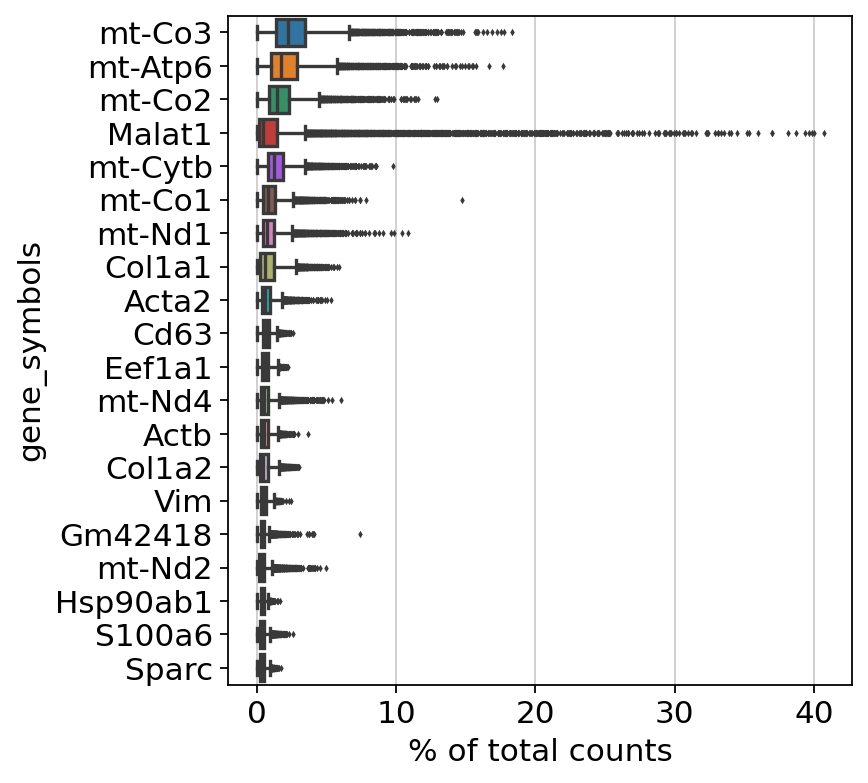

In [ ]:
sc.pl.highest_expr_genes(adata_A, n_top=20)

## Filtering

In [ ]:
# Perform basic filtering
sc.pp.filter_cells(adata_A, min_genes=50)
sc.pp.filter_genes(adata_A, min_cells=3)

filtered out 11554 genes that are detected in less than 3 cells


In [ ]:
# Evaluate thresholds for quality control based on the following metrics for each cell:
#   % of counts from mitochondrial genes
#   total # counts
#   # genes expressed
adata_A.var['mt'] = adata_A.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_A, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

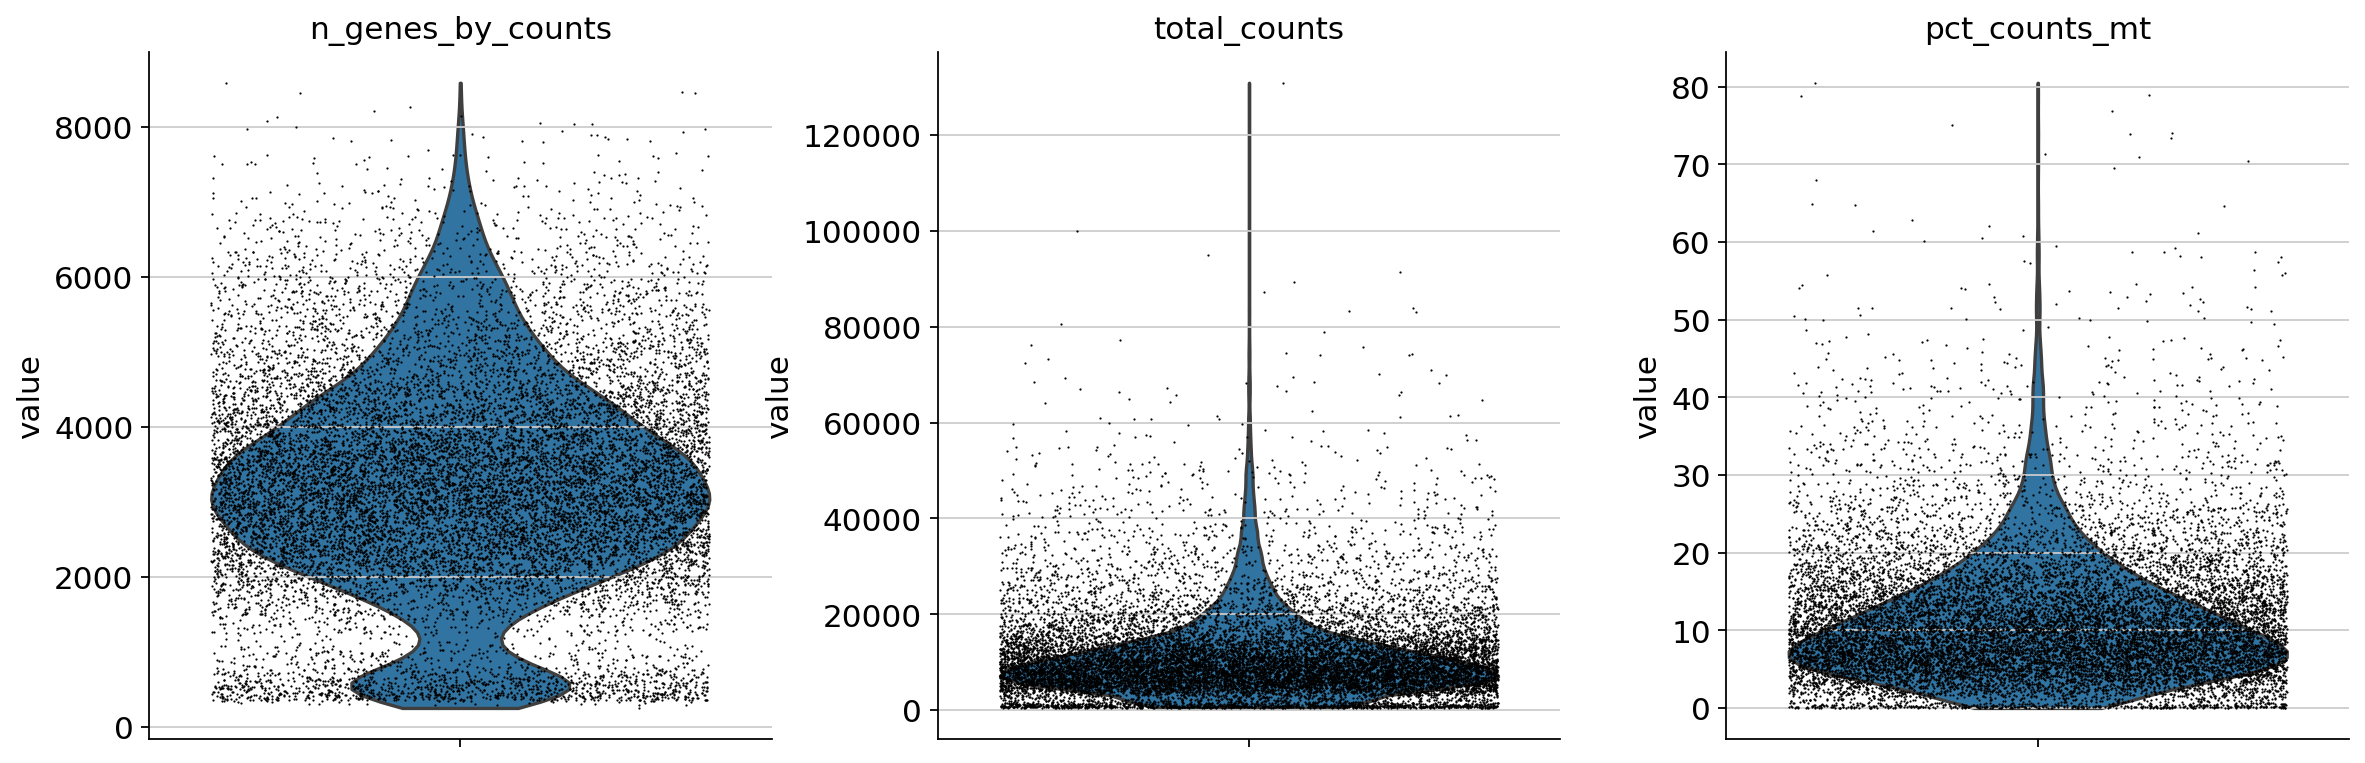

In [ ]:
sc.pl.violin(
    adata_A, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True
)


Some general observations
* Recall that CellRanger does some filtering, and we did a bit of additional filtering above
* We would like to filter out samples with very high `total_counts`, since these are unlikely to be single cells
* There are many genes with a very high percentage of mitochondrial counts. This could indicate a high metabolic activity and/or a lower sample quality. We will play it safe and only exclude samples with very high fractions. Let's take a closer look.

Text(0, 0.5, 'Number of cells')

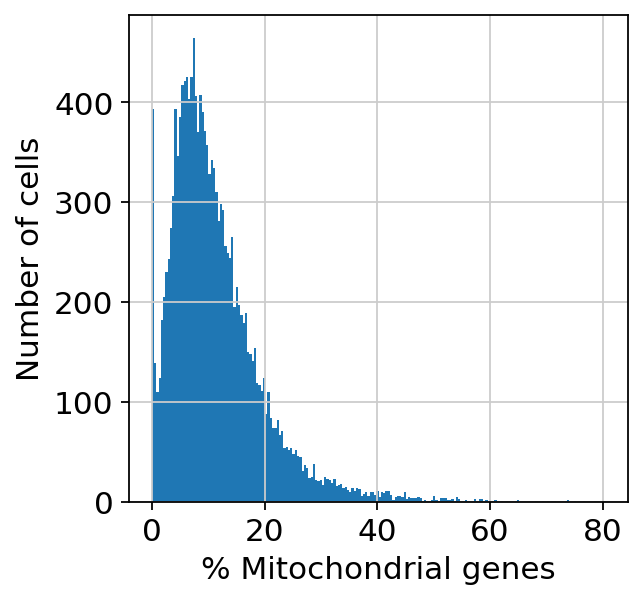

In [ ]:
# Plot a histogram of the percent of counts from mitochondrial genes
plt.hist(adata_A.obs.pct_counts_mt, bins=200)
plt.xlabel("% Mitochondrial genes")
plt.ylabel("Number of cells")

Text(0, 0.5, '# Genes expressed')

<Figure size 320x320 with 0 Axes>

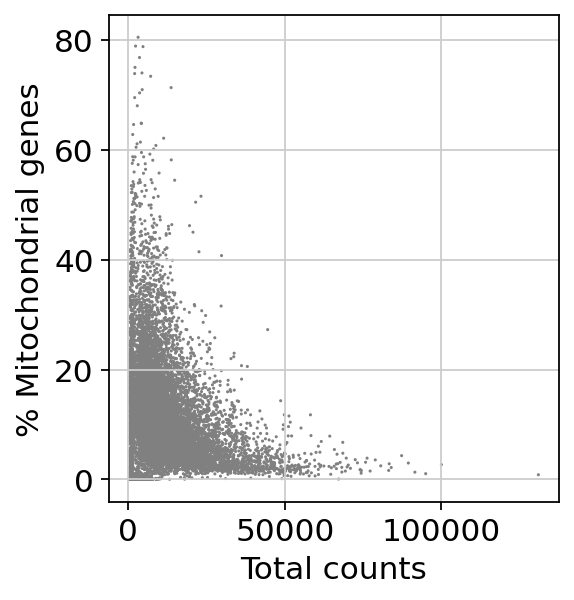

<Figure size 320x320 with 0 Axes>

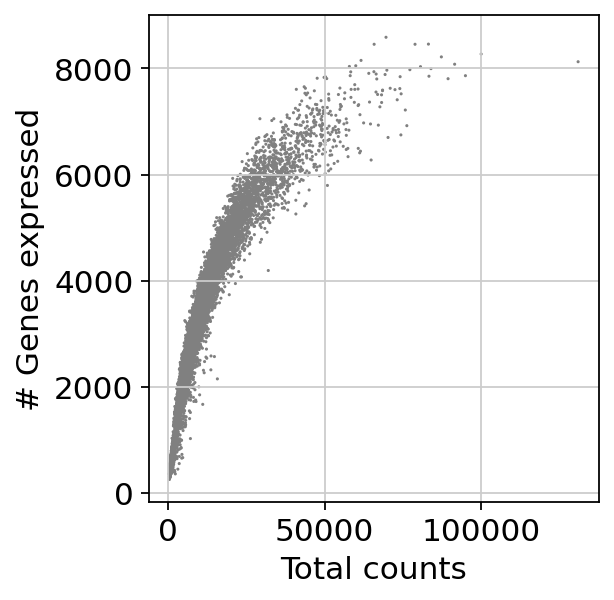

In [ ]:
# Set a thresholds for total counts to exclude possible doublets
total_counts_thresh = 80_000

# Set a threshold for mitochondrial gene content to exclude possible dying cells
mt_pct_thresh = 55

# Plot covariate information
fig = plt.figure()
sc.pl.scatter(adata_A, x='total_counts', y='pct_counts_mt', show=False)
plt.xlabel("Total counts")
plt.ylabel("% Mitochondrial genes")
# plt.axhline(y=mt_pct_thresh, color='red');
# plt.axvline(x=total_counts_thresh, color='red');

fig = plt.figure()
sc.pl.scatter(adata_A, x='total_counts', y='n_genes_by_counts', show=False)
plt.xlabel("Total counts")
plt.ylabel("# Genes expressed")
# plt.axvline(x=total_counts_thresh, color='red');

In [ ]:
# Perform additional filtering
adata_A = adata_A[adata_A.obs['total_counts'] < total_counts_thresh, :]
adata_A = adata_A[adata_A.obs['pct_counts_mt'] < mt_pct_thresh, :]

## Normalization

In [ ]:
# Normalize to 10,000 counts per cell
sc.pp.normalize_total(adata_A, target_sum=1e4)

# Logarithmize the data for fold-change analysis
sc.pp.log1p(adata_A)

normalizing counts per cell


/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


## Additional preprocessing

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


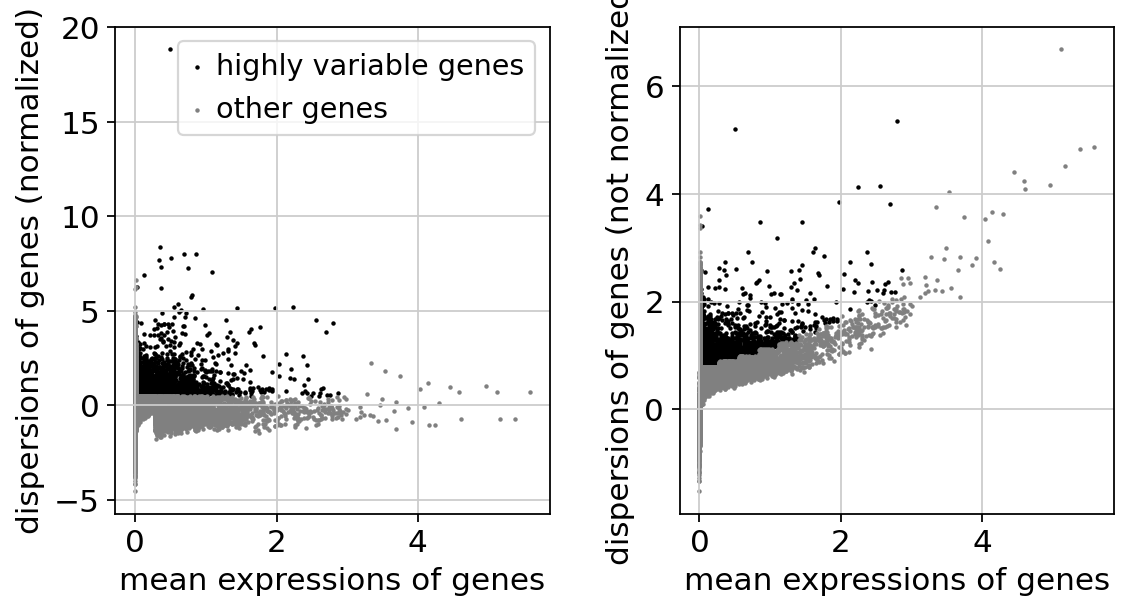

In [ ]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata_A, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot
sc.pl.highly_variable_genes(adata_A)

### Regress out the effects of gene dosage (total counts and % mitochondrial counts)

Uncomment the below to run (can take a while)

In [ ]:
# # Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
# adata_A.raw = adata_A
# sc.pp.regress_out(adata_A, ['total_counts', 'pct_counts_mt'])

# # Scale the data to unit variance and clip values exceeding standard deviation 10
# sc.pp.scale(adata_A, max_value=10)

----

# Sample B

In [ ]:
# Read in the data
# X_B = mmread(data_dir.joinpath("samples_B/outs/count/filtered_feature_bc_matrix/matrix.mtx.gz")).T.tocsr()

sample_dir_B = data_dir.joinpath(
    "samples_B/outs/count/filtered_feature_bc_matrix"
)
barcodes_B = pd.read_csv(sample_dir_B.joinpath("barcodes.tsv.gz"), header=None, index_col=0, delimiter="\t")
genes_B = pd.read_csv(sample_dir_B.joinpath("features.tsv.gz"), header=None, index_col=1, delimiter="\t")
adata_B = sc.AnnData(X=X_B, obs=barcodes_B, var=genes_B)

# Rename the variable columns and index to be more informative
adata_B.var.rename(columns={0: "gene_ids", 2: "feature_types"}, inplace=True)
adata_B.var.rename_axis("gene_symbols", inplace=True)
adata_B.var_names_make_unique()

# Peek at the AnnData object
print(adata_B)
print("\nadata.var:")
print(adata_B.var)
print("\nadata.obs:")
print(adata_B.obs)

AnnData object with n_obs × n_vars = 22623 × 32285
    var: 'gene_ids', 'feature_types'

adata.var:
                        gene_ids    feature_types
gene_symbols                                     
Xkr4          ENSMUSG00000051951  Gene Expression
Gm1992        ENSMUSG00000089699  Gene Expression
Gm19938       ENSMUSG00000102331  Gene Expression
Gm37381       ENSMUSG00000102343  Gene Expression
Rp1           ENSMUSG00000025900  Gene Expression
...                          ...              ...
AC124606.1    ENSMUSG00000095523  Gene Expression
AC133095.2    ENSMUSG00000095475  Gene Expression
AC133095.1    ENSMUSG00000094855  Gene Expression
AC234645.1    ENSMUSG00000095019  Gene Expression
AC149090.1    ENSMUSG00000095041  Gene Expression

[32285 rows x 2 columns]

adata.obs:
Empty DataFrame
Columns: []
Index: [AAACCCAAGAGCAAGA-1, AAACCCAAGGAATCGC-1, AAACCCAAGGCCATAG-1, AAACCCAAGGGCCCTT-1, AAACCCACACGATAGG-1, AAACCCACATGAATAG-1, AAACCCAGTTGATGTC-1, AAACCCATCATTGCGA-1, AAACCCATCGAACTCA

/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell
    finished (0:00:00)


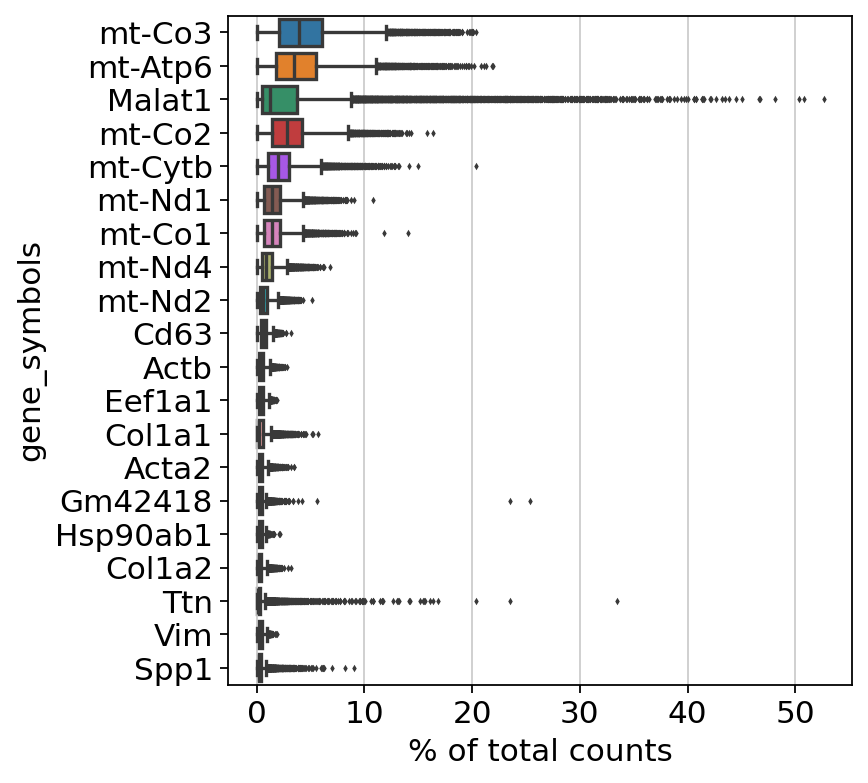

In [ ]:
sc.pl.highest_expr_genes(adata_B, n_top=20)

filtered out 9603 genes that are detected in less than 3 cells


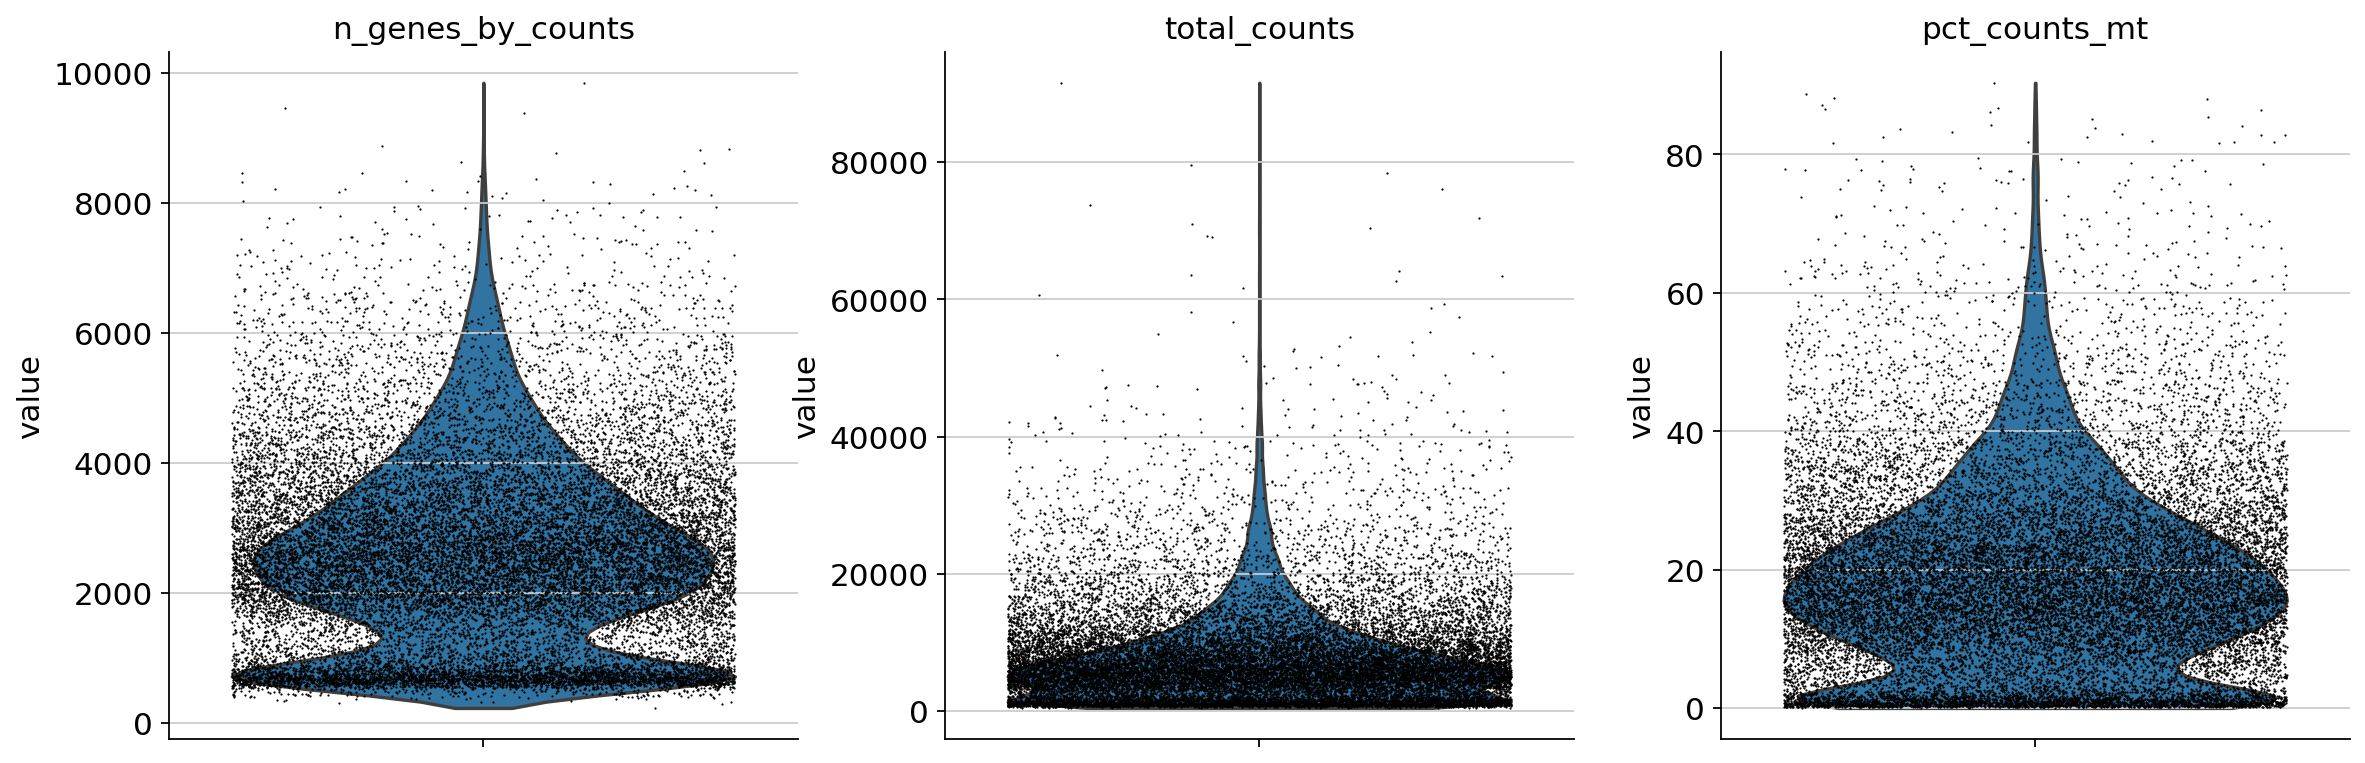

In [ ]:
# Perform basic filtering
sc.pp.filter_cells(adata_B, min_genes=50)
sc.pp.filter_genes(adata_B, min_cells=3)

# Evaluate thresholds for quality control based on the following metrics for each cell:
#   % of counts from mitochondrial genes
#   total # counts
#   # genes expressed
adata_B.var['mt'] = adata_B.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_B, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
    adata_B, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True
)


Text(0, 0.5, '# Genes expressed')

<Figure size 320x320 with 0 Axes>

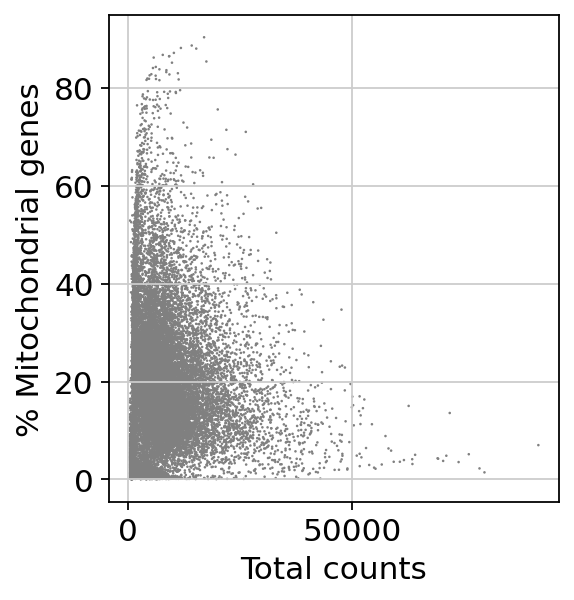

<Figure size 320x320 with 0 Axes>

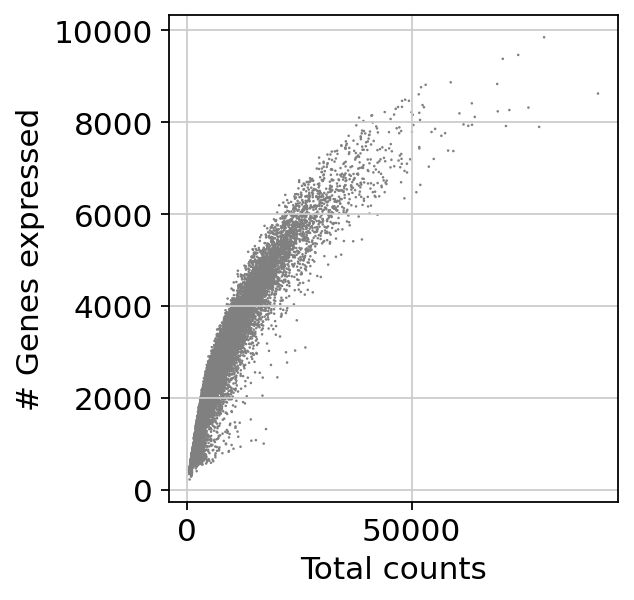

In [ ]:
# Plot covariate information
fig = plt.figure()
sc.pl.scatter(adata_B, x='total_counts', y='pct_counts_mt', show=False)
plt.xlabel("Total counts")
plt.ylabel("% Mitochondrial genes")

fig = plt.figure()
sc.pl.scatter(adata_B, x='total_counts', y='n_genes_by_counts', show=False)
plt.xlabel("Total counts")
plt.ylabel("# Genes expressed")

----

# Sample C

In [ ]:
# Read in the data
# X_C = mmread(data_dir.joinpath("samples_C/outs/count/filtered_feature_bc_matrix/matrix.mtx.gz")).T.tocsr()

sample_dir_C = data_dir.joinpath(
    "samples_C/outs/count/filtered_feature_bc_matrix"
)
barcodes_C = pd.read_csv(sample_dir_C.joinpath("barcodes.tsv.gz"), header=None, index_col=0, delimiter="\t")
genes_C = pd.read_csv(sample_dir_C.joinpath("features.tsv.gz"), header=None, index_col=1, delimiter="\t")
adata_C = sc.AnnData(X=X_C, obs=barcodes_C, var=genes_C)

# Rename the variable columns and index to be more informative
adata_C.var.rename(columns={0: "gene_ids", 2: "feature_types"}, inplace=True)
adata_C.var.rename_axis("gene_symbols", inplace=True)
adata_C.var_names_make_unique()

# Peek at the AnnData object
print(adata_C)
print("\nadata.var:")
print(adata_C.var)
print("\nadata.obs:")
print(adata_C.obs)

AnnData object with n_obs × n_vars = 20756 × 32285
    var: 'gene_ids', 'feature_types'

adata.var:
                        gene_ids    feature_types
gene_symbols                                     
Xkr4          ENSMUSG00000051951  Gene Expression
Gm1992        ENSMUSG00000089699  Gene Expression
Gm19938       ENSMUSG00000102331  Gene Expression
Gm37381       ENSMUSG00000102343  Gene Expression
Rp1           ENSMUSG00000025900  Gene Expression
...                          ...              ...
AC124606.1    ENSMUSG00000095523  Gene Expression
AC133095.2    ENSMUSG00000095475  Gene Expression
AC133095.1    ENSMUSG00000094855  Gene Expression
AC234645.1    ENSMUSG00000095019  Gene Expression
AC149090.1    ENSMUSG00000095041  Gene Expression

[32285 rows x 2 columns]

adata.obs:
Empty DataFrame
Columns: []
Index: [AAACCCAAGGTCCTGC-1, AAACCCACACGTTCGG-1, AAACCCAGTGACGTCC-1, AAACCCAGTGCAAGAC-1, AAACCCAGTTGTCATG-1, AAACCCATCAATCCGA-1, AAACCCATCCCAGGAC-1, AAACCCATCGAGATAA-1, AAACCCATCGCAGTCG

/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell
    finished (0:00:00)


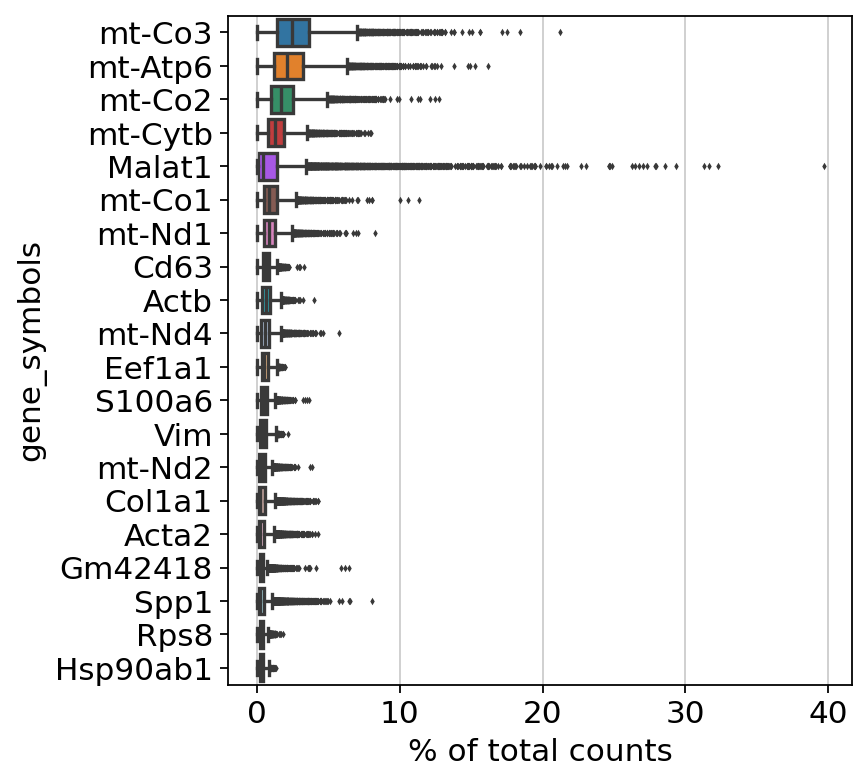

In [ ]:
sc.pl.highest_expr_genes(adata_C, n_top=20)

filtered out 10168 genes that are detected in less than 3 cells


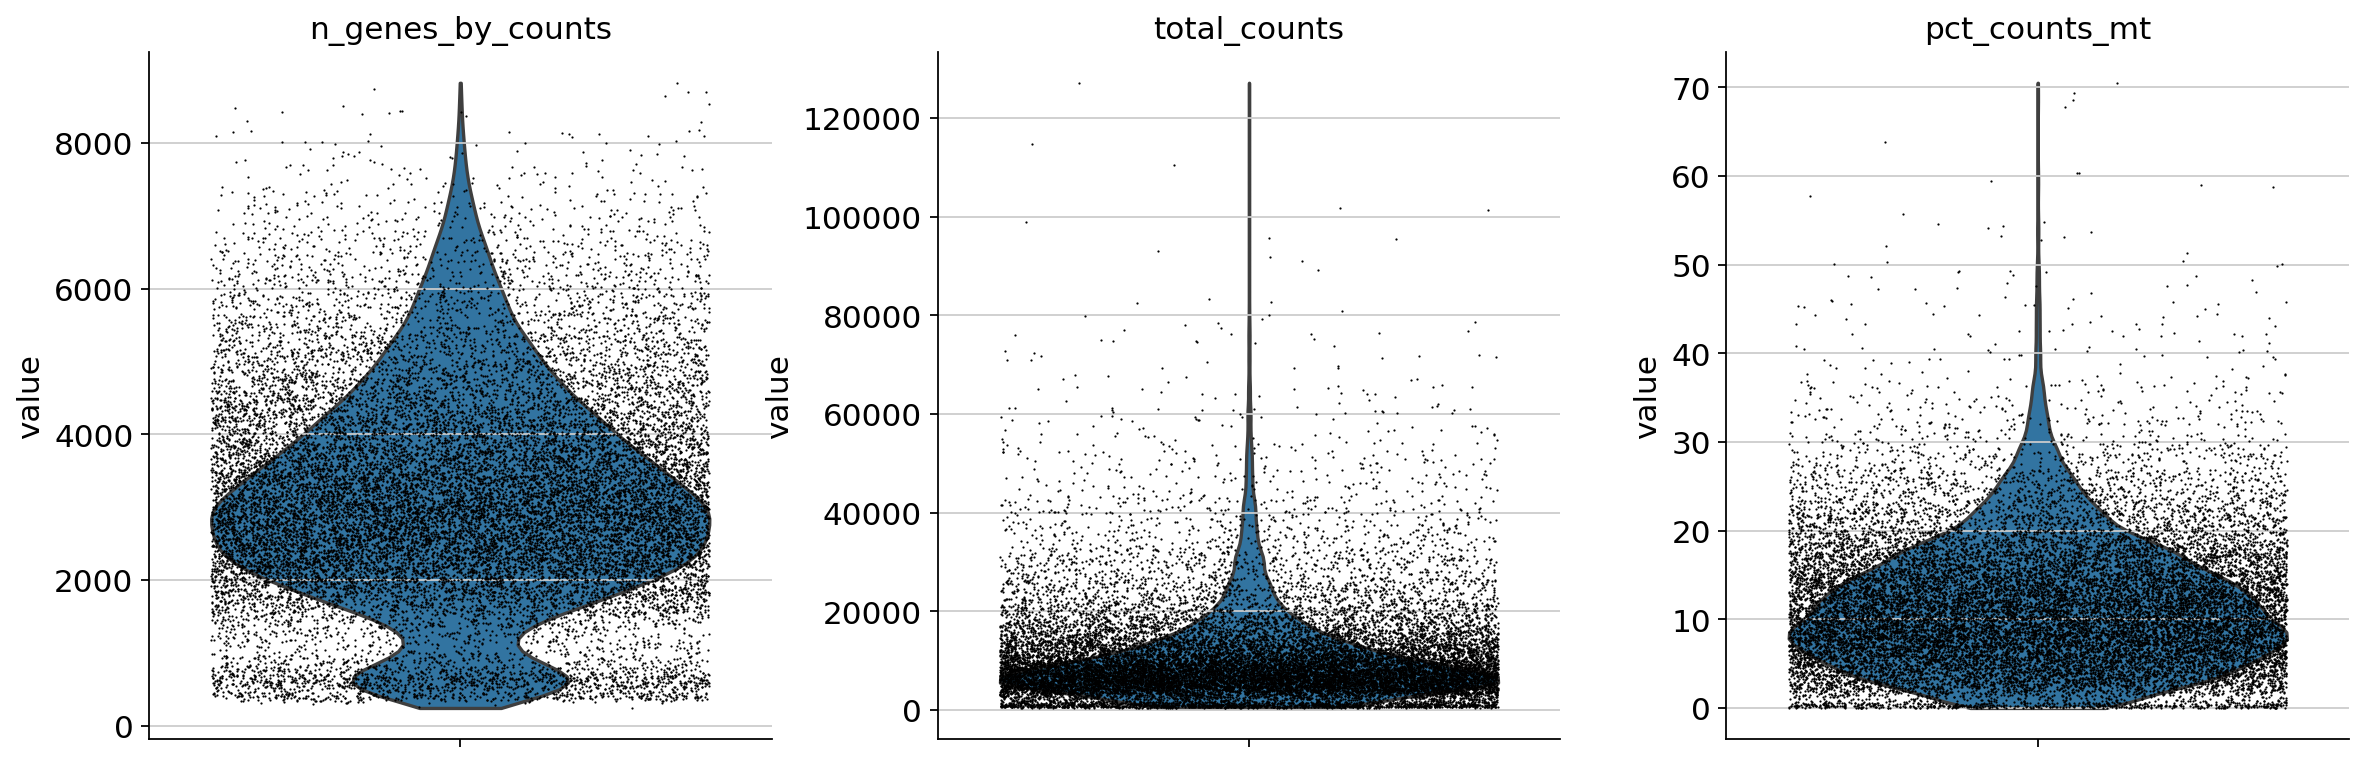

In [ ]:
# Perform basic filtering
sc.pp.filter_cells(adata_C, min_genes=50)
sc.pp.filter_genes(adata_C, min_cells=3)

# Evaluate thresholds for quality control based on the following metrics for each cell:
#   % of counts from mitochondrial genes
#   total # counts
#   # genes expressed
adata_C.var['mt'] = adata_C.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_C, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
    adata_C, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True
)


Text(0, 0.5, '# Genes expressed')

<Figure size 320x320 with 0 Axes>

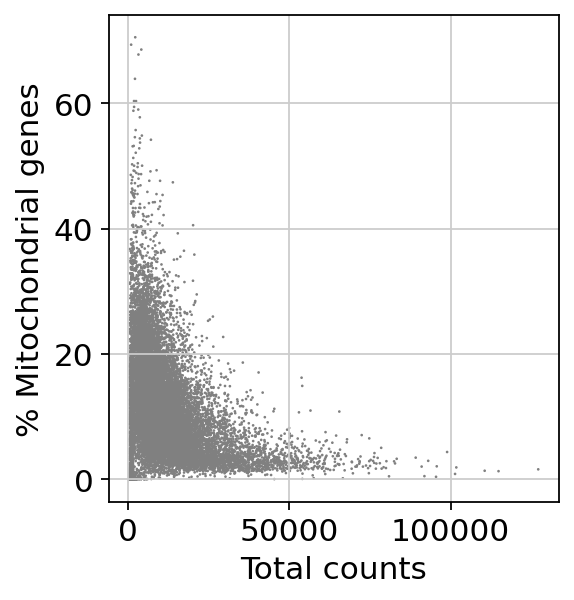

<Figure size 320x320 with 0 Axes>

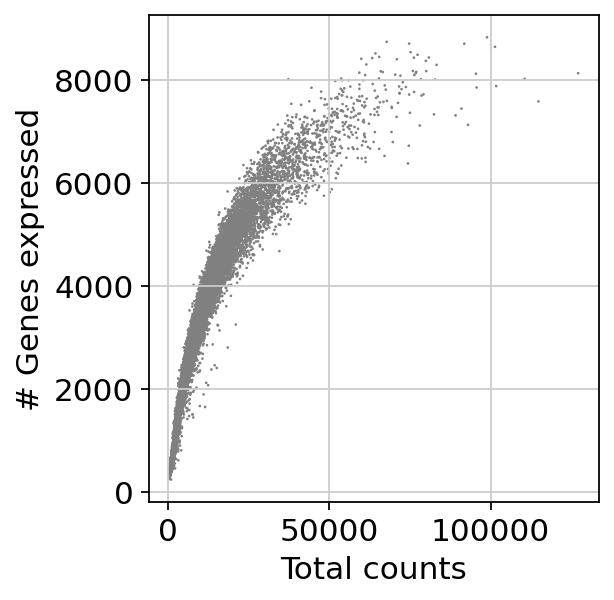

In [ ]:
# Plot covariate information
fig = plt.figure()
sc.pl.scatter(adata_C, x='total_counts', y='pct_counts_mt', show=False)
plt.xlabel("Total counts")
plt.ylabel("% Mitochondrial genes")

fig = plt.figure()
sc.pl.scatter(adata_C, x='total_counts', y='n_genes_by_counts', show=False)
plt.xlabel("Total counts")
plt.ylabel("# Genes expressed")

----

# Sample D

In [ ]:
# Read in the data
# X_D = mmread(data_dir.joinpath("samples_D/outs/count/filtered_feature_bc_matrix/matrix.mtx.gz")).T.tocsr()

sample_dir_D = data_dir.joinpath(
    "samples_D/outs/count/filtered_feature_bc_matrix"
)
barcodes_D = pd.read_csv(sample_dir_D.joinpath("barcodes.tsv.gz"), header=None, index_col=0, delimiter="\t")
genes_D = pd.read_csv(sample_dir_D.joinpath("features.tsv.gz"), header=None, index_col=1, delimiter="\t")
adata_D = sc.AnnData(X=X_D, obs=barcodes_D, var=genes_D)

# Rename the variable columns and index to be more informative
adata_D.var.rename(columns={0: "gene_ids", 2: "feature_types"}, inplace=True)
adata_D.var.rename_axis("gene_symbols", inplace=True)
adata_D.var_names_make_unique()

# Peek at the AnnData object
print(adata_D)
print("\nadata.var:")
print(adata_D.var)
print("\nadata.obs:")
print(adata_D.obs)

AnnData object with n_obs × n_vars = 25216 × 32285
    var: 'gene_ids', 'feature_types'

adata.var:
                        gene_ids    feature_types
gene_symbols                                     
Xkr4          ENSMUSG00000051951  Gene Expression
Gm1992        ENSMUSG00000089699  Gene Expression
Gm19938       ENSMUSG00000102331  Gene Expression
Gm37381       ENSMUSG00000102343  Gene Expression
Rp1           ENSMUSG00000025900  Gene Expression
...                          ...              ...
AC124606.1    ENSMUSG00000095523  Gene Expression
AC133095.2    ENSMUSG00000095475  Gene Expression
AC133095.1    ENSMUSG00000094855  Gene Expression
AC234645.1    ENSMUSG00000095019  Gene Expression
AC149090.1    ENSMUSG00000095041  Gene Expression

[32285 rows x 2 columns]

adata.obs:
Empty DataFrame
Columns: []
Index: [AAACCCAAGCCTCTCT-1, AAACCCAAGCGACTAG-1, AAACCCAGTCTACTGA-1, AAACCCAGTTGCTCCT-1, AAACCCATCACTACTT-1, AAACGAAAGTTAGTAG-1, AAACGAACAGCTTCCT-1, AAACGAACATGGACAG-1, AAACGAAGTACCAGAG

/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell


    finished (0:00:00)


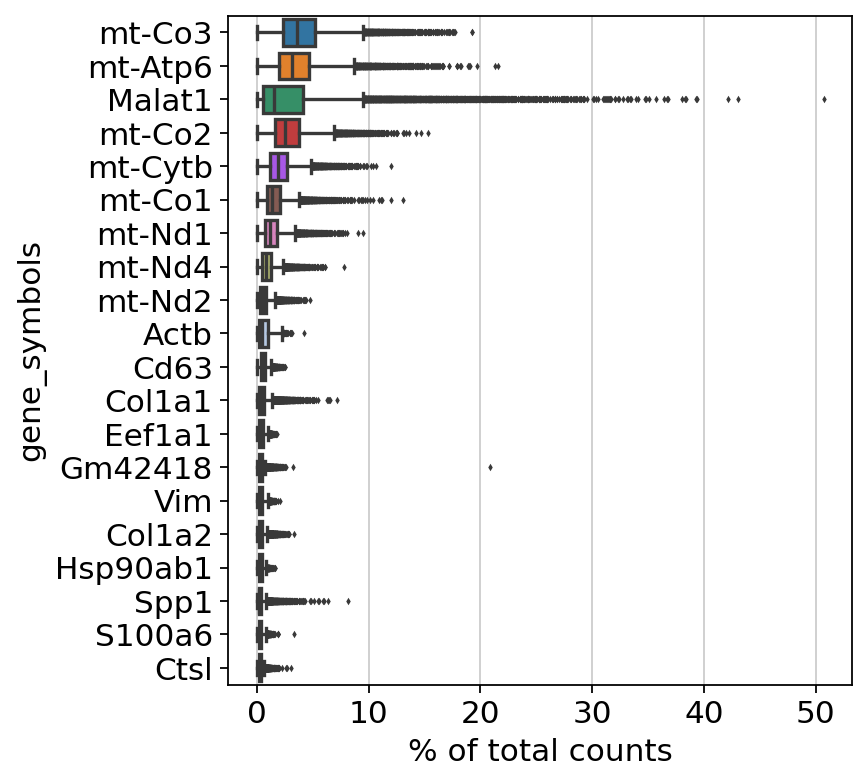

In [ ]:
sc.pl.highest_expr_genes(adata_D, n_top=20)

filtered out 9593 genes that are detected in less than 3 cells


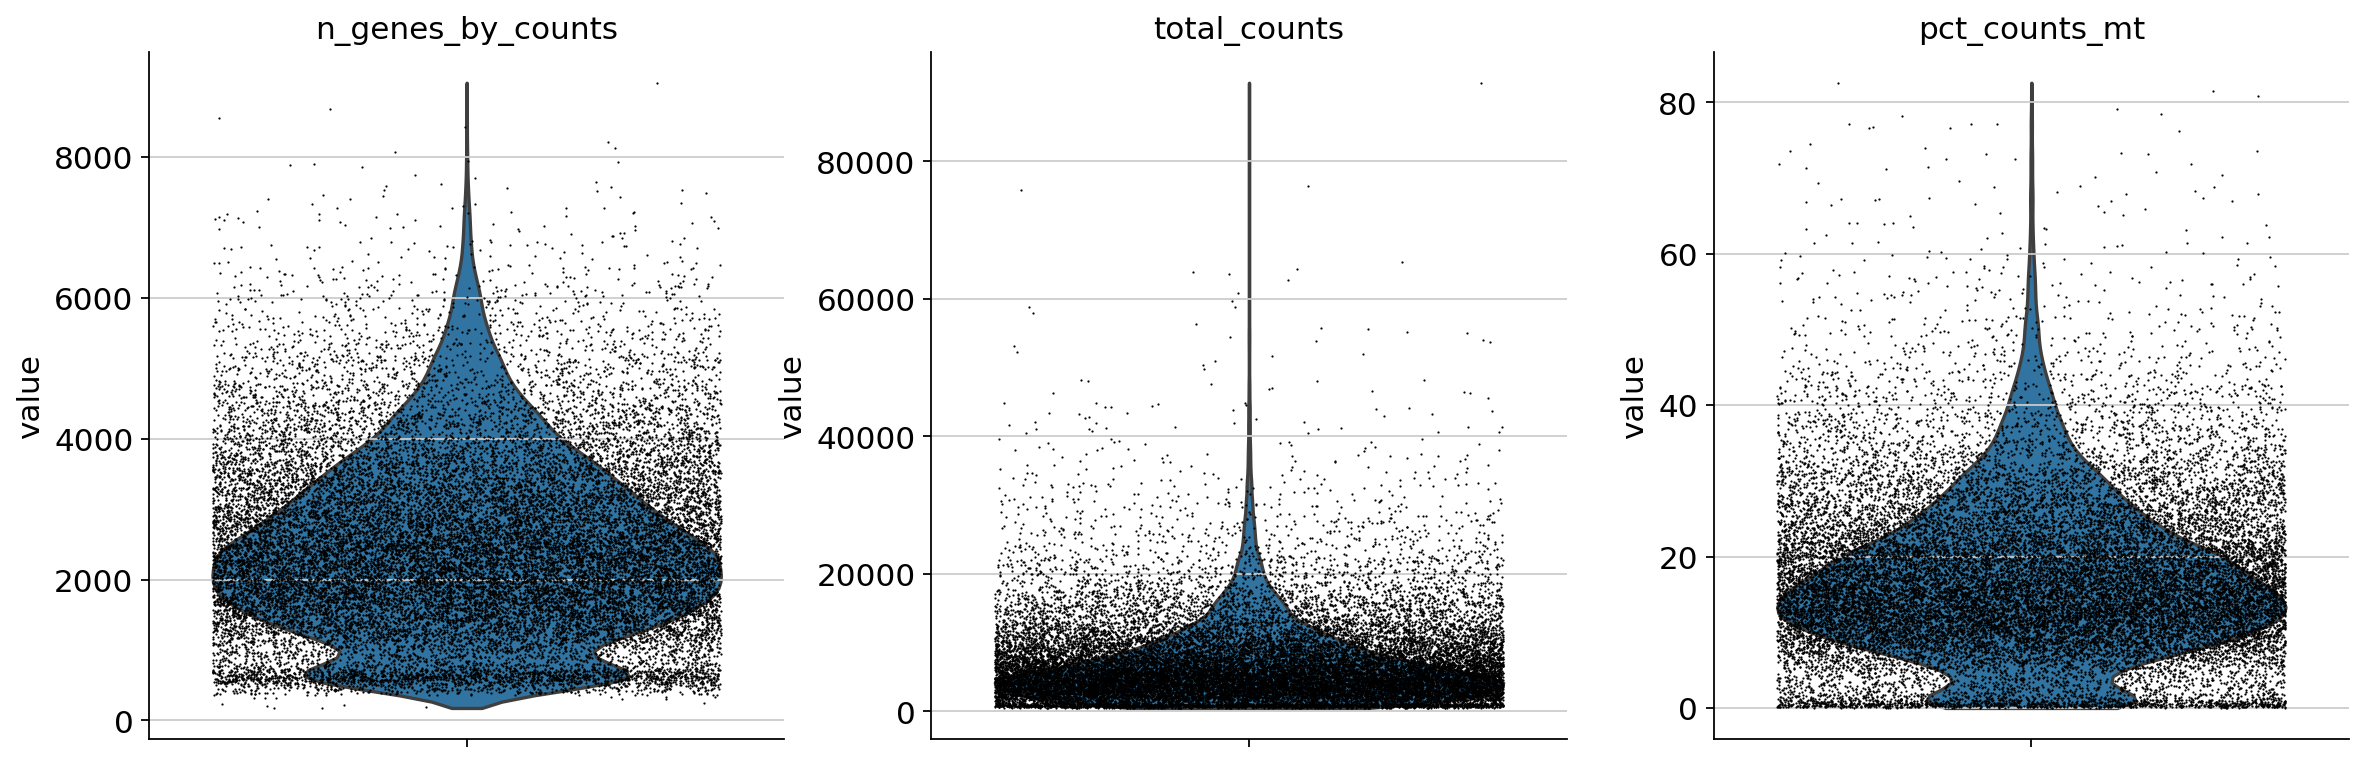

In [ ]:
# Perform basic filtering
sc.pp.filter_cells(adata_D, min_genes=50)
sc.pp.filter_genes(adata_D, min_cells=3)

# Evaluate thresholds for quality control based on the following metrics for each cell:
#   % of counts from mitochondrial genes
#   total # counts
#   # genes expressed
adata_D.var['mt'] = adata_D.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_D, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
    adata_D, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True
)


Text(0, 0.5, '% Mitochondrial genes')

<Figure size 320x320 with 0 Axes>

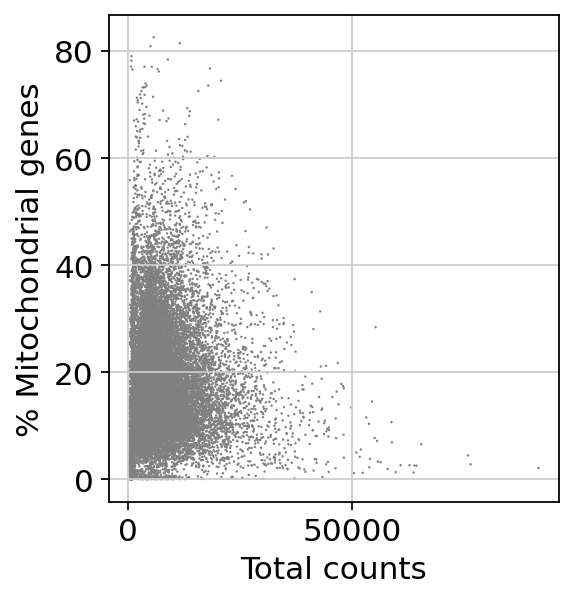

<Figure size 320x320 with 0 Axes>

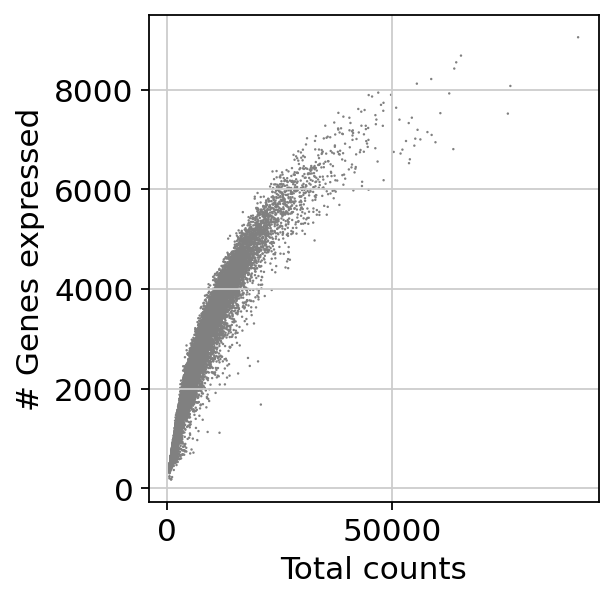

<Figure size 320x320 with 0 Axes>

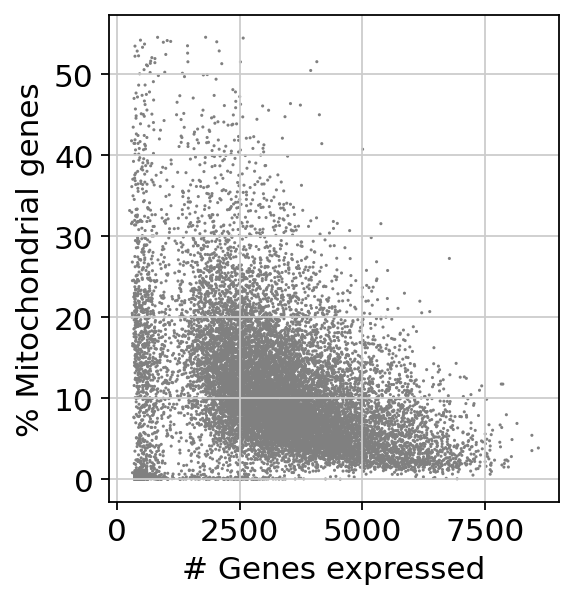

In [ ]:
# Plot covariate information
fig = plt.figure()
sc.pl.scatter(adata_D, x='total_counts', y='pct_counts_mt', show=False)
plt.xlabel("Total counts")
plt.ylabel("% Mitochondrial genes")

fig = plt.figure()
sc.pl.scatter(adata_D, x='total_counts', y='n_genes_by_counts', show=False)
plt.xlabel("Total counts")
plt.ylabel("# Genes expressed")

fig = plt.figure()
sc.pl.scatter(adata_A, x='n_genes_by_counts', y='pct_counts_mt', show=False)
plt.xlabel("# Genes expressed")
plt.ylabel("% Mitochondrial genes")

---

# Summary plotting

In [ ]:
import seaborn as sns

<Figure size 800x800 with 0 Axes>

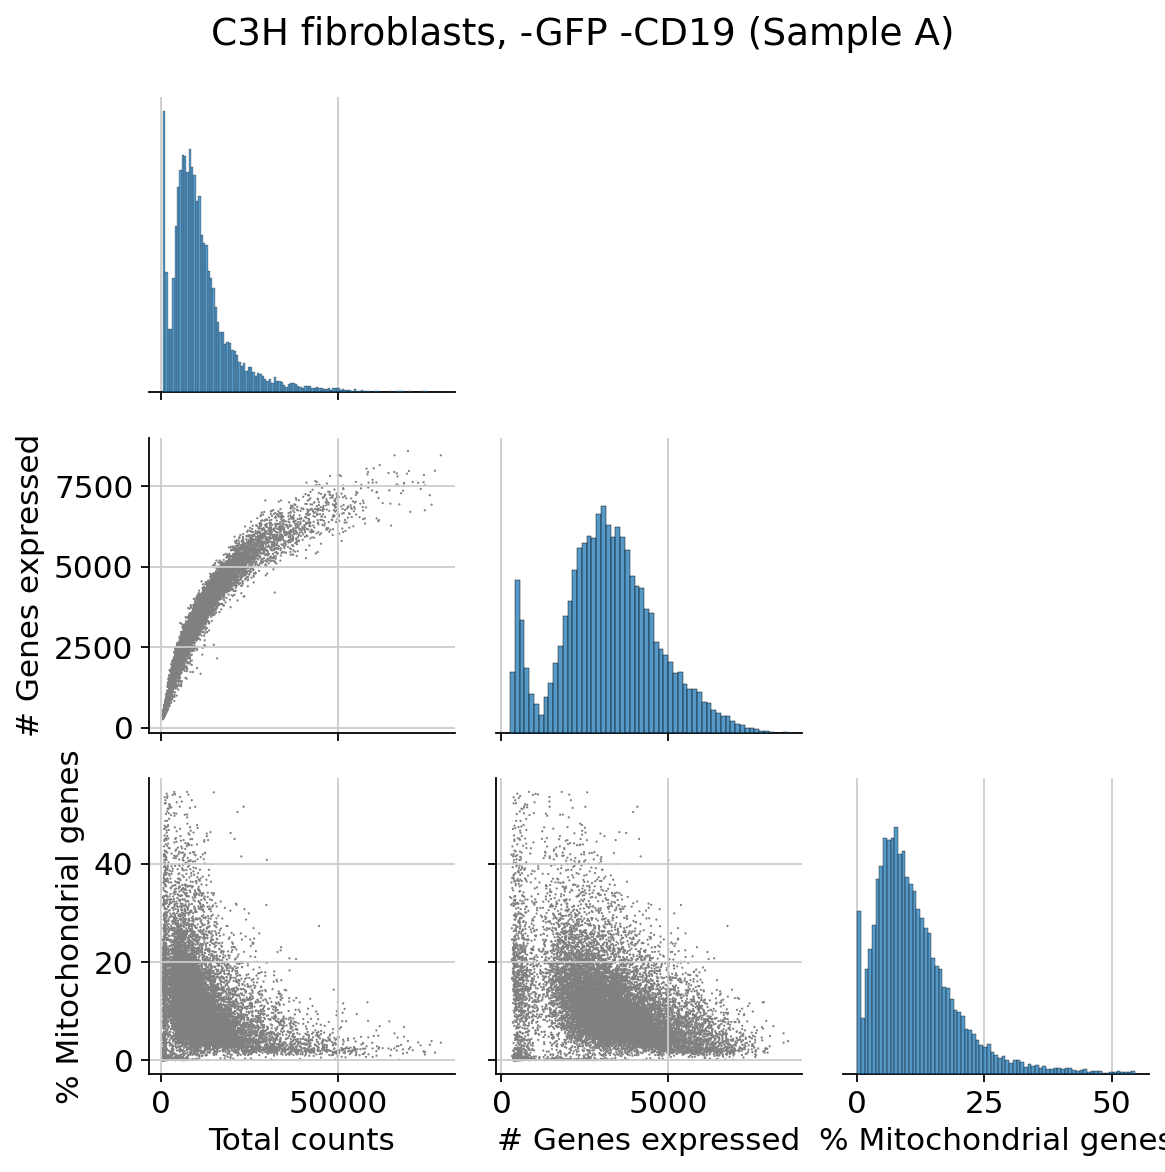

In [ ]:
# Plot a pairplot of the covariates
df_A = adata_A.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']]
df_A.columns = ['Total counts', '# Genes expressed', '% Mitochondrial genes']

fig = plt.figure(figsize=(10, 10))
sns.pairplot(
    df_A,
    corner=True,
    plot_kws=dict(marker='o', alpha=1, color='gray', edgecolor='none', s=1),
)

plt.suptitle("C3H fibroblasts, -GFP -CD19 (Sample A)")
plt.tight_layout()

# Set dpi to 300
fig.savefig("pairplot_A.png", dpi=300)

<Figure size 800x800 with 0 Axes>

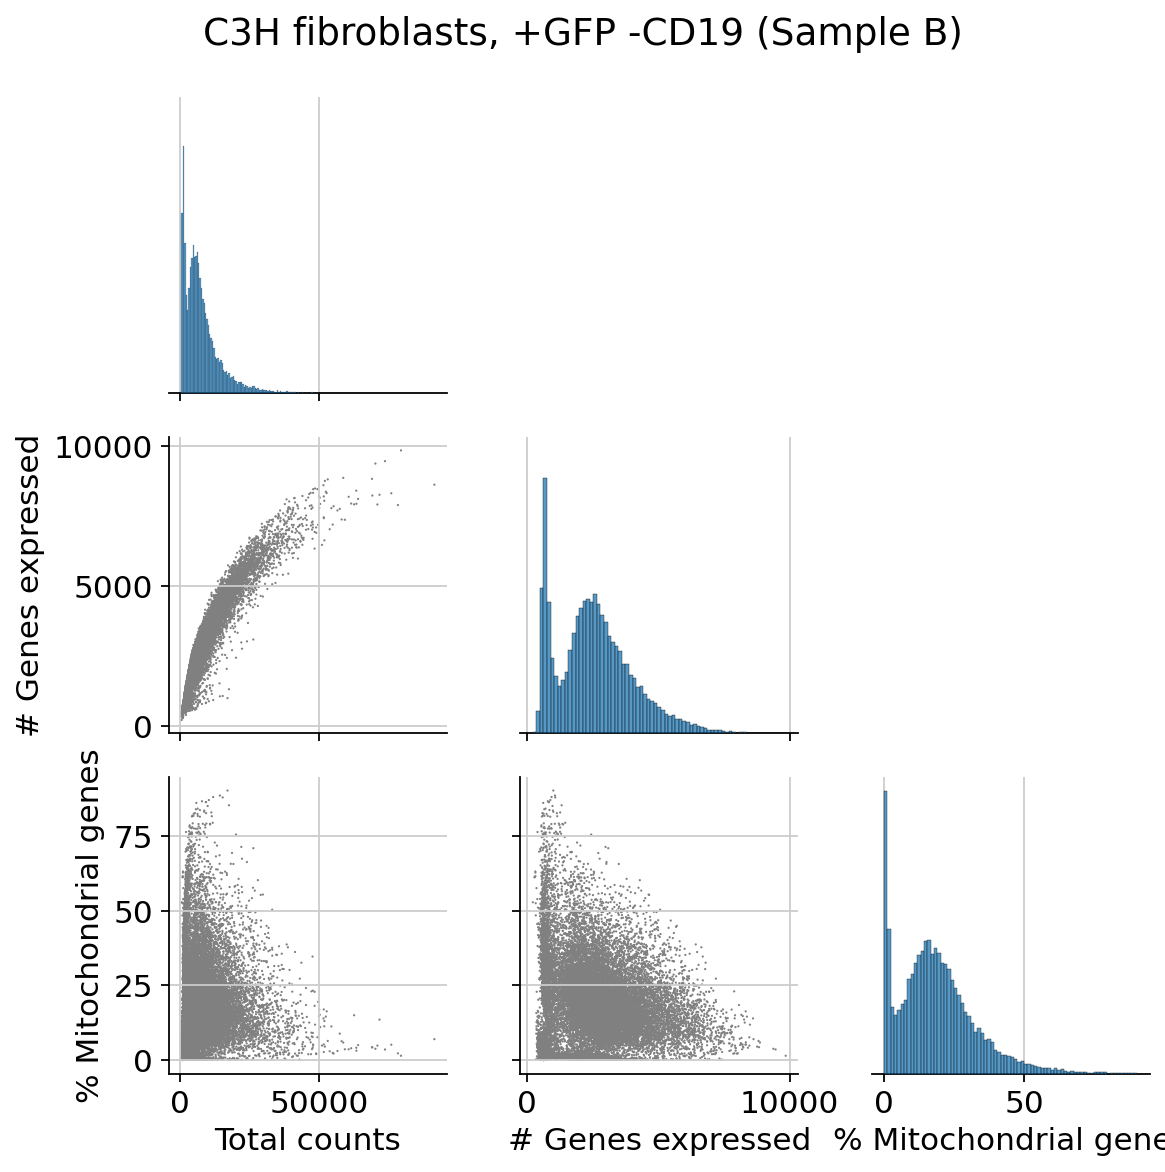

In [ ]:
# Plot a pairplot of the covariates
df_B = adata_B.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']]
df_B.columns = ['Total counts', '# Genes expressed', '% Mitochondrial genes']

fig = plt.figure(figsize=(10, 10))
sns.pairplot(
    df_B,
    corner=True,
    plot_kws=dict(marker='o', alpha=1, color='gray', edgecolor='none', s=1),
)

plt.suptitle("C3H fibroblasts, +GFP -CD19 (Sample B)")
plt.tight_layout()

# Set dpi to 300
fig.savefig("pairplot_B.png", dpi=300)

<Figure size 800x800 with 0 Axes>

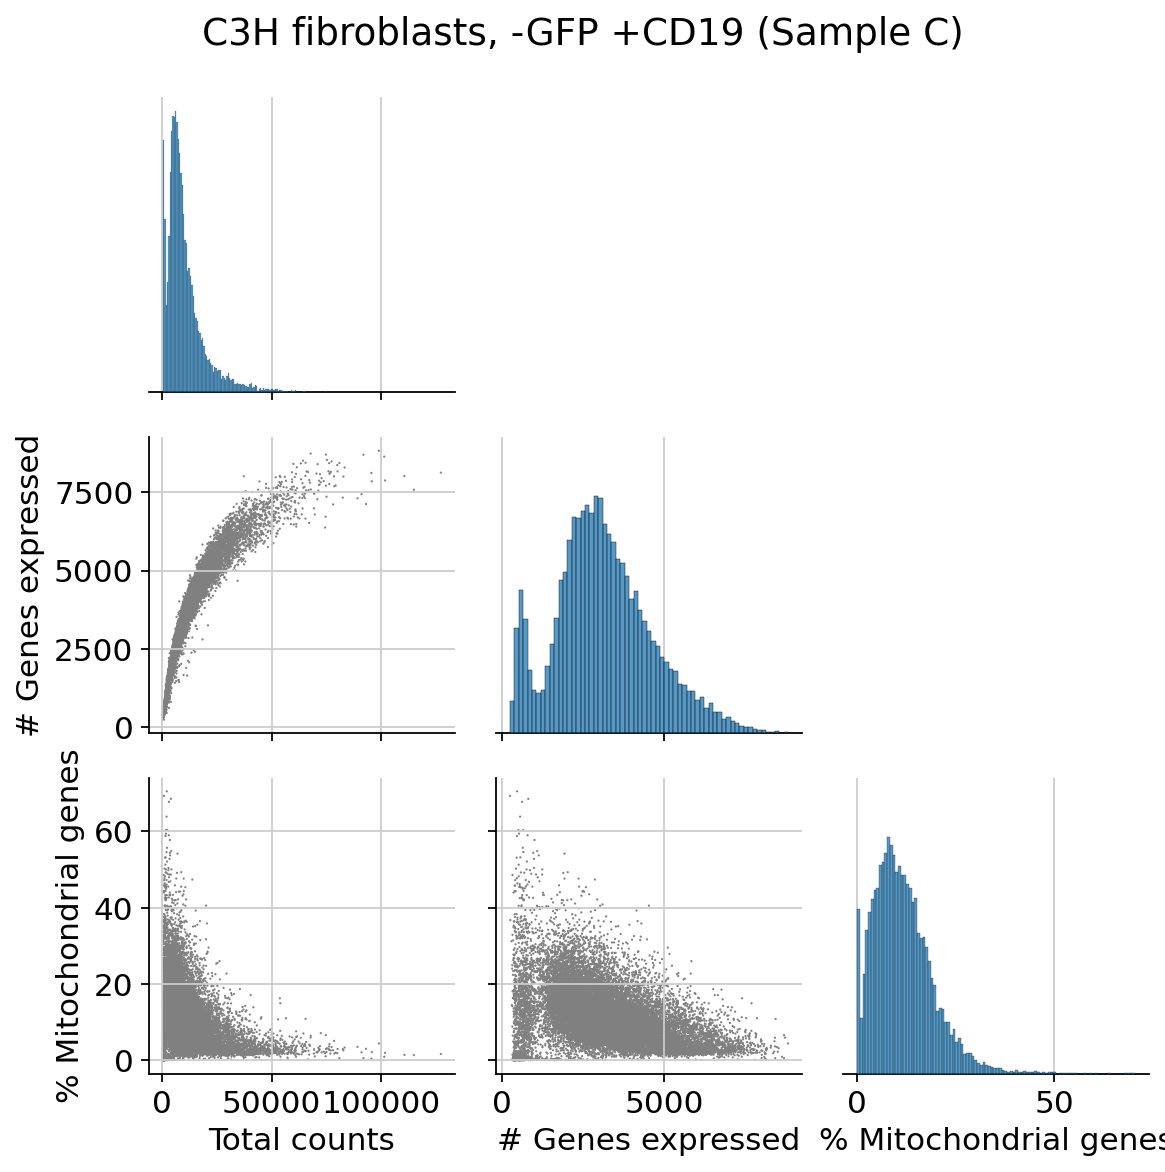

In [ ]:
# Plot a pairplot of the covariates
df_C = adata_C.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']]
df_C.columns = ['Total counts', '# Genes expressed', '% Mitochondrial genes']

fig = plt.figure(figsize=(10, 10))
sns.pairplot(
    df_C,
    corner=True,
    plot_kws=dict(marker='o', alpha=1, color='gray', edgecolor='none', s=1),
)

plt.suptitle("C3H fibroblasts, -GFP +CD19 (Sample C)")
plt.tight_layout()

# Set dpi to 300
fig.savefig("pairplot_C.png", dpi=300)

<Figure size 800x800 with 0 Axes>

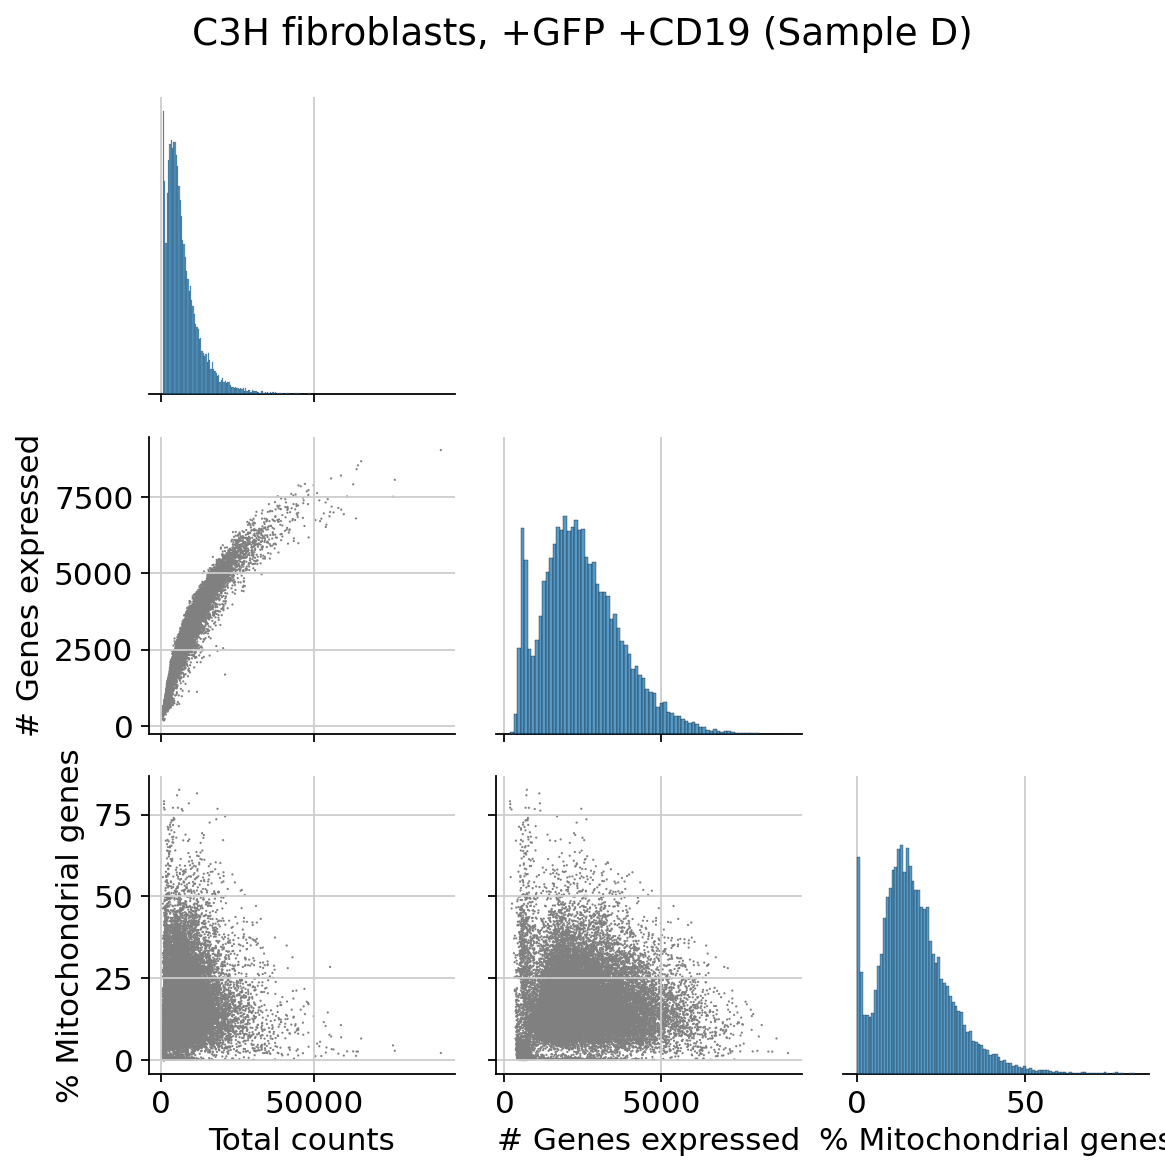

In [ ]:
# Plot a pairplot of the covariates
df_D = adata_D.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']]
df_D.columns = ['Total counts', '# Genes expressed', '% Mitochondrial genes']

fig = plt.figure(figsize=(10, 10))
sns.pairplot(
    df_D,
    corner=True,
    plot_kws=dict(marker='o', alpha=1, color='gray', edgecolor='none', s=1),
)

plt.suptitle("C3H fibroblasts, +GFP +CD19 (Sample D)")
plt.tight_layout()

# Set dpi to 300
fig.savefig("pairplot_D.png", dpi=300)